In [54]:
import os
import pandas as pd
import numpy as np
from stock_reader import reader
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import logging
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import GRU
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.engine.input_layer import Input
from keras import backend as K
from keras.models import Model

In [55]:
from tensorflow import set_random_seed
set_random_seed(7)
np.random.seed(7)

In [56]:
look_back = 1

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [57]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
class Attention(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


Enter Code or Symbol :  000660
Enter start date(YYYY-MM--DD) :  20070101
Enter end date(YYYY-MM--DD) :  20200101



     Symbol    Name   Sector
223  000660  SK하이닉스  반도체 제조업

             open   high    low  close   volume    change
Date                                                     
2007-01-02  36900  37550  36700  37300  4461871  0.023320
2007-01-03  37550  37700  36950  36950  3827777 -0.009383
2007-01-04  37100  37550  36850  37150  4410444  0.005413
2007-01-05  37400  37550  36400  37400  5935841  0.006729
2007-01-08  37200  37350  36500  36650  3436598 -0.020053
...           ...    ...    ...    ...      ...       ...
2019-12-23  95800  96200  94100  94600  1720279 -0.004211
2019-12-24  95000  95600  93800  93800  1464093 -0.008457
2019-12-26  94000  95100  93500  94800  1559839  0.010661
2019-12-27  94800  97000  94200  96000  2229470  0.012658
2019-12-30  95600  96300  94100  94100  1862634 -0.019792

[3213 rows x 6 columns]


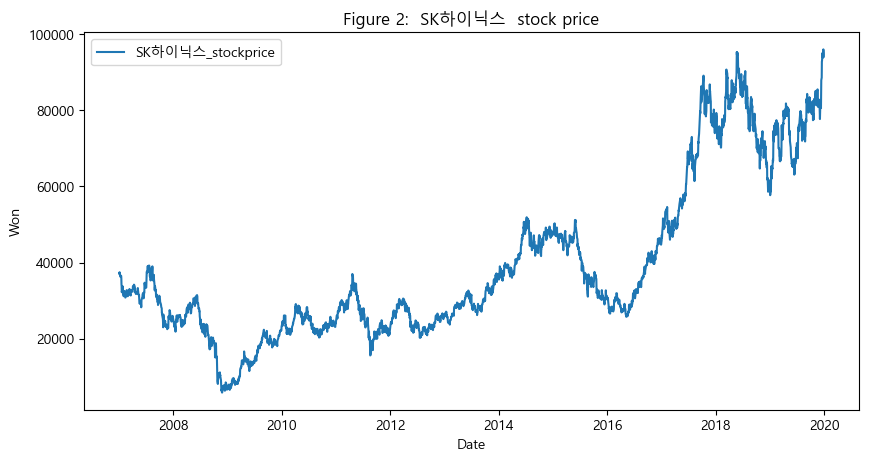


There are 3213 number of days in the dataset.



In [58]:
if __name__ == '__main__':
    stock_code = '005930'  # 삼성전자

    # 주식 데이터 준비
    pandf = reader()

    # 기간 필터링
#    pandf = chart_data[(chart_data['date'] >= '2010-11-01') &
#                                  (chart_data['date'] <= '2017-12-31')]
#    pandf = pandf.dropna()
    # convert nparray
    nparr = pandf['close'].values[::-1].reshape(-1,1)
    nparr.astype('float32')

In [59]:
    nparr = pandf['close'].values[::].reshape(-1,1)
    nparr.astype('float32')
    nptf1=np.array(pandf)
    print(nptf1)
    print("nparr :",nparr.shape,"nptf1 :",nptf1.shape)
    

[[ 3.69000000e+04  3.75500000e+04  3.67000000e+04  3.73000000e+04
   4.46187100e+06  2.33196159e-02]
 [ 3.75500000e+04  3.77000000e+04  3.69500000e+04  3.69500000e+04
   3.82777700e+06 -9.38337802e-03]
 [ 3.71000000e+04  3.75500000e+04  3.68500000e+04  3.71500000e+04
   4.41044400e+06  5.41271989e-03]
 ...
 [ 9.40000000e+04  9.51000000e+04  9.35000000e+04  9.48000000e+04
   1.55983900e+06  1.06609808e-02]
 [ 9.48000000e+04  9.70000000e+04  9.42000000e+04  9.60000000e+04
   2.22947000e+06  1.26582278e-02]
 [ 9.56000000e+04  9.63000000e+04  9.41000000e+04  9.41000000e+04
   1.86263400e+06 -1.97916667e-02]]
nparr : (3213, 1) nptf1 : (3213, 6)


In [64]:
    # normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
#    nptf = scaler.fit_transform(nparr)
    nptf = scaler.fit_transform(nparr)
    print(nptf.shape)

    # split train, test
    train_size = int(len(nptf) * 0.9)
    test_size = len(nptf) - train_size
    train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
    print(len(train), len(test))

    # create dataset for learning
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    print("trainX :",trainX.shape,"trainY :",trainY.shape,"testX :",testX.shape,"testY :",testY.shape ,"(행,열,피처)")
    

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[2])) # trainX.shape[1] --> [2] 로 바꿈 )
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))
  #  print(trainX)
  #  print(testX)

(3213, 1)
2891 322
trainX : (2889, 1, 1) trainY : (2889, 1) testX : (320, 1, 1) testY : (320, 1) (행,열,피처)


In [65]:
    # simple lstm network learning
    model = Sequential()
    model.add(LSTM(128,  return_sequences=True, activation="relu", input_shape=(1, look_back))) # input_shape=(1, look_back) --> (X_train.shape[1], X_train.shape[2]) 
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Attention(look_back))
#    model.add(LSTM(128,  return_sequences=False, activation="relu", input_shape=(1, look_back)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    #model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae'])
    model.summary()
    
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1, 128)            66560     
_________________________________________________________________
dropout_29 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 1, 128)            512       
_________________________________________________________________
attention_15 (Attention)     (None, 128)               129       
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512       
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total para

In [68]:
    from keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1) # early_stop 
    model.fit(trainX, trainY, epochs=40, batch_size=32, verbose=2,callbacks=[early_stop])

    # make prediction
    testPredict = model.predict(testX)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Train Score: %.2f RMSE' % testScore)

    # predict last value (or tomorrow?)
    lastX = nptf[-1]
    lastX = np.reshape(lastX, (1, 1, 1))
    lastY = model.predict(lastX)
    lastY = scaler.inverse_transform(lastY)
    print('Predict the Close value of final day: %d' % lastY)  # 데이터 입력 마지막 다음날 종가 예측


Epoch 1/40
 - 2s - loss: 0.0243 - mean_absolute_error: 0.1155
Epoch 2/40
 - 1s - loss: 0.0103 - mean_absolute_error: 0.0744
Epoch 3/40
 - 1s - loss: 0.0067 - mean_absolute_error: 0.0581
Epoch 4/40
 - 1s - loss: 0.0035 - mean_absolute_error: 0.0437
Epoch 5/40
 - 1s - loss: 0.0031 - mean_absolute_error: 0.0414
Epoch 6/40
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0398
Epoch 7/40
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0391
Epoch 8/40
 - 1s - loss: 0.0020 - mean_absolute_error: 0.0337
Epoch 9/40
 - 1s - loss: 0.0029 - mean_absolute_error: 0.0399
Epoch 00009: early stopping
Train Score: 2668.22 RMSE
Predict the Close value of final day: 88743


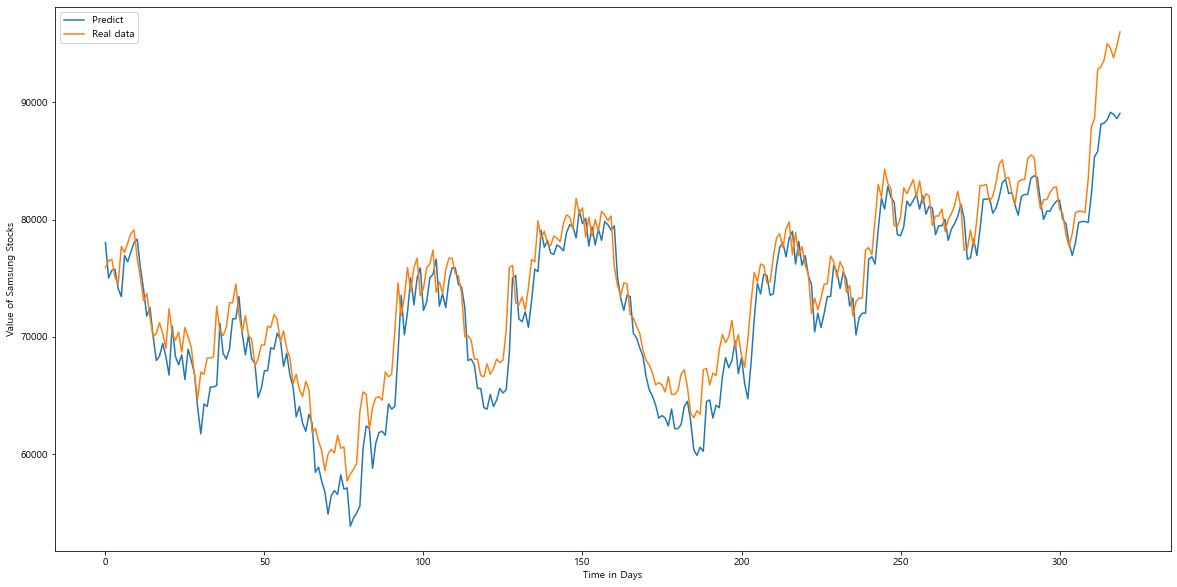

In [69]:
# plot
    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot(testPredict, label = 'Predict')
    plt.plot(testY, label = 'Real data')
    plt.xlabel('Time in Days')
    plt.ylabel('Value of Samsung Stocks')
    plt.legend(loc = 'upper left')
    plt.show()

In [70]:
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = '1scale.pkl' 
joblib.dump(scaler, file_name) 

['1scale.pkl']

In [57]:
from keras.models import load_model
model.save('1SAMSUNGLSTM.h5')

In [61]:
ys=joblib.load('1scale.pkl')
LSTM = load_model('1SAMSUNGLSTM.h5') #어텐션을 저장을 못함

ValueError: Unknown layer: Attention

#TRAIDNG

In [71]:
count = int(np.ceil(len(pandf) * 0.1))
signals = pd.DataFrame(index=pandf.index)
signals['signal'] = 0.0
signals['trend'] = pandf['close']

signals=signals[-testPredict.shape[0]:]
signals['predict'] = testPredict
signals.loc[signals['predict'] < signals.trend, 'signal'] = -1 # 매도 selling
signals.loc[signals['predict'] >= signals.trend * 1.007, 'signal'] = 1 #매수 buying
signals.reset_index(drop=True, inplace=True)
signals

,signal,trend,predict
0,1.0,76500,78036.156250
1,-1.0,76600,75013.671875
2,1.0,75100,75667.039062
3,1.0,74500,75774.515625
4,-1.0,77700,74119.898438
...,...,...,...
315,-1.0,94600,88512.664062
316,-1.0,93800,89142.734375
317,-1.0,94800,88967.867188
318,-1.0,96000,88605.812500


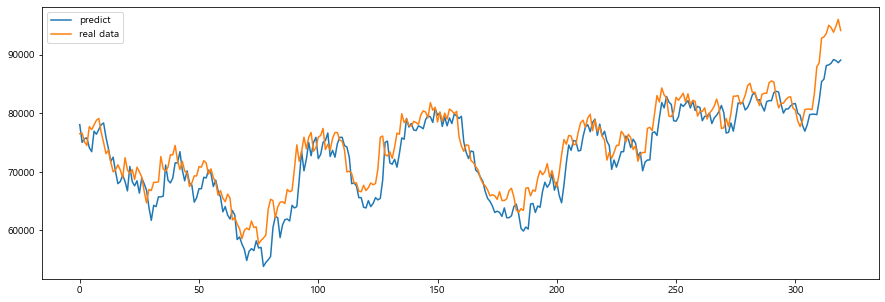

In [72]:
plt.figure(figsize = (15,5))
plt.plot(signals['predict'],label='predict')
plt.plot(signals['trend'],label='real data')
plt.legend(loc = 'upper left')

In [73]:
def buy_stock( ## 클래스로 바꿔야할듯 
    real_movement,
    signal,
    predict,
    initial_money = 10000000,
    max_buy = 100,
    max_sell = 100,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    global 평단가,거래금
    states_real_buy=[]
    states_real_sell=[]
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0
    평단가 = 0
    거래금 = 0

    def buy(i, initial_money, current_inventory):
        global 평단가, 거래금
        
        shares = initial_money // real_movement[i]
        if shares < 1: # 가지고 있는 돈이 주가보다 낮을 경우 
            print(
                'day %d: 현재 잔고 : %d, 매수금이 부족합니다. 현재 주가 : %d'
                % (i, initial_money, real_movement[i])
            )
        else: # 가지고 있는 돈이 살수 있는 주가보다 높을 경우 
            states_real_buy.append(i) 
           # if shares > max_buy: 
            if predict[i] > real_movement[i] * 1.015 : 
                buy_units = min(shares , max_buy*3) # 수익률이 1.5% 이상이면 300주 매수 
            elif predict[i] > real_movement[i] * 1.01 : 
                buy_units = min(shares , max_buy*2) # 수익률이 1% 이상이면 200주 매수
            elif predict[i] > real_movement[i] * 1.007 : 
                buy_units = min(shares , max_buy*1) # 수익률이 0.7% 이상이면 100주 매수 
            else:
                buy_units = 0
                states_real_buy.pop(-1)
                #buy_units = shares # 살수 있는 만큼 산다. 
            initial_money -= buy_units * real_movement[i]
            거래금 += buy_units * real_movement[i]
            
            current_inventory += buy_units
            평단가 = 거래금 // current_inventory
            
            print(
                'day %d: 주문수량 : %d 주문수량 * 매수가 : %d, 현재 잔고 : %d, 주식 보유량 : %d, 평단가 :%0.2f '
                % (i, buy_units, buy_units * real_movement[i], initial_money, current_inventory,평단가)
            )
            states_buy.append(0) # 주식을 샀을 경우 0을 붙혀줌
            ####
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(signals))):
        state = signal[i]
        if state == 1: ##########signal 1 매수 
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
            #### 시그널 1일때 날짜를 붙혀줌
        elif state == -1: ########### signal -1 매도
            if current_inventory == 0:
                    print('day %d: 보유량이 없어서 매도를 하지 않았습니다' % (i))
            else:
                states_real_sell.append(i)
               # if current_inventory > max_sell: 
                ### 평단가에 따른 분할 매도 진행  (수익률이 0.7 )
                if real_movement[i] > 평단가 *1.015 : 
                    sell_units = min(current_inventory,max_sell*3) # 수익률이 1.5% 이상이면 300주 매도                                                          
                elif real_movement[i] > 평단가*1.01 :
                    sell_units = min(current_inventory,max_sell*2) # 수익률이 1% 이상이면 200주 매도 
                elif real_movement[i] > 평단가*1.007 :
                    sell_units = min(current_inventory,max_sell*1) # 수익률이 0.7% 이상이면 100주 매도
                else: 
                    sell_units = 0
                    states_real_sell.pop(-1)
                    
              #  else:
               #     sell_units = current_inventory                  
                current_inventory -= sell_units # 판다
                거래금 -= sell_units * real_movement[i]
                평단가 = 거래금 // current_inventory
                
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = ( 
                        np.log(real_movement[i] / real_movement[states_buy[-1]])
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, 매도량 : %d 매도가 : %d, 수익률: %0.2f %%, 현재 잔고 : %d, 주식 보유량 : %d, 평단가 : %0.2f'
                    % (i, sell_units, total_sell, invest, initial_money, current_inventory, 평단가)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, current_inventory,states_real_buy,states_real_sell

In [74]:
states_buy, states_sell, total_gains, invest,current_inventory,states_real_buy,states_real_sell = buy_stock(signals['trend'], signals['signal'], signals['predict'])

day 0: 주문수량 : 130 주문수량 * 매수가 : 9945000, 현재 잔고 : 55000, 주식 보유량 : 130, 평단가 :76500.00 
day 1, 매도량 : 0 매도가 : 0, 수익률: 0.13 %, 현재 잔고 : 55000, 주식 보유량 : 130, 평단가 : 76500.00
day 2: 현재 잔고 : 55000, 매수금이 부족합니다. 현재 주가 : 75100
day 3: 현재 잔고 : 55000, 매수금이 부족합니다. 현재 주가 : 74500
day 4, 매도량 : 130 매도가 : 10101000, 수익률: 4.21 %, 현재 잔고 : 10156000, 주식 보유량 : 0, 평단가 : 0.00
day 5: 보유량이 없어서 매도를 하지 않았습니다
day 6: 보유량이 없어서 매도를 하지 않았습니다
day 7: 보유량이 없어서 매도를 하지 않았습니다
day 8: 보유량이 없어서 매도를 하지 않았습니다
day 9: 주문수량 : 132 주문수량 * 매수가 : 10124400, 현재 잔고 : 31600, 주식 보유량 : 132, 평단가 :75518.00 
day 10: 현재 잔고 : 31600, 매수금이 부족합니다. 현재 주가 : 75000
day 11: 현재 잔고 : 31600, 매수금이 부족합니다. 현재 주가 : 73100
day 14: 현재 잔고 : 31600, 매수금이 부족합니다. 현재 주가 : 70000
day 15, 매도량 : 0 매도가 : 0, 수익률: 0.43 %, 현재 잔고 : 31600, 주식 보유량 : 132, 평단가 : 75518.00
day 16, 매도량 : 0 매도가 : 0, 수익률: 1.70 %, 현재 잔고 : 31600, 주식 보유량 : 132, 평단가 : 75518.00
day 17, 매도량 : 0 매도가 : 0, 수익률: 0.43 %, 현재 잔고 : 31600, 주식 보유량 : 132, 평단가 : 75518.00
day 19, 매도량 : 0 매도가 : 0, 수익률: 3.37 %, 현재 잔고 : 31600, 주식 보유

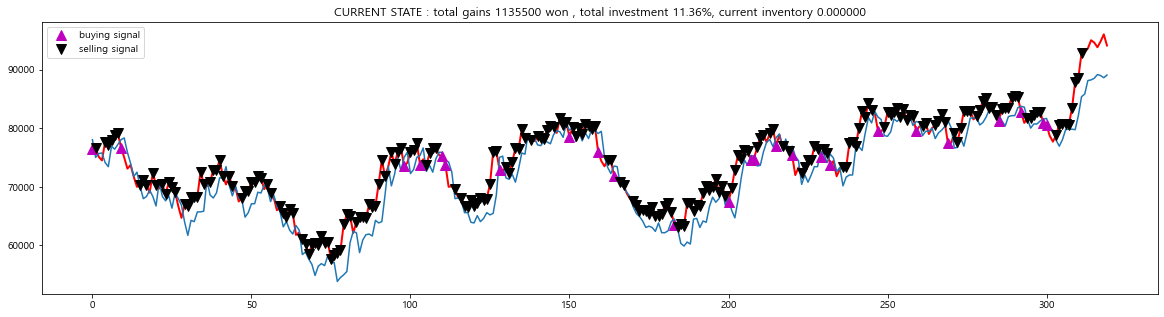

currnet profit(in value) :  1135500


In [79]:
close = signals['trend']
fig = plt.figure(figsize = (20,5))
plt.plot(close, color='r', lw=2.)
plt.plot(signals['predict'])
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_real_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('CURRENT STATE : total gains %d won , total investment %0.2f%%, current inventory %f'%(total_gains, invest, current_inventory))
plt.legend()
plt.show()

profit = (close.iloc[-1]*current_inventory)+total_gains
print("currnet profit(in value) : ", profit)

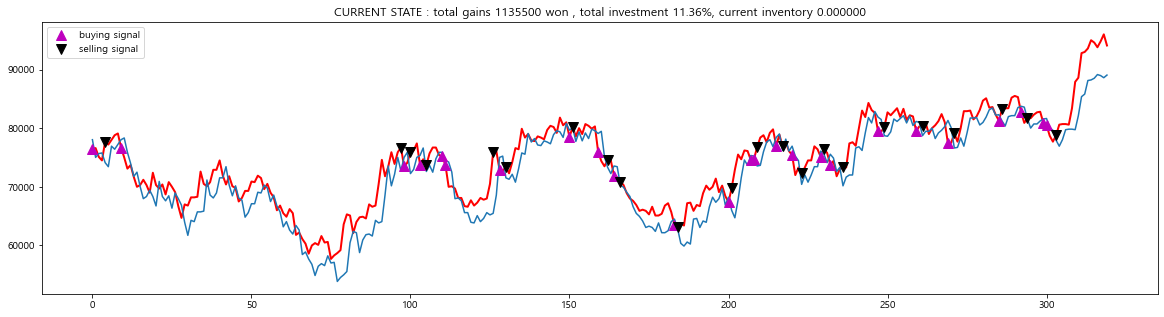

currnet profit(in value) :  1135500


In [78]:
close = signals['trend']
fig = plt.figure(figsize = (20,5))
plt.plot(close, color='r', lw=2.)
plt.plot(signals['predict'])
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_real_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_real_sell)
plt.title('CURRENT STATE : total gains %d won , total investment %0.2f%%, current inventory %f'%(total_gains, invest, current_inventory))
plt.legend()
plt.show()

profit = (close.iloc[-1]*current_inventory)+total_gains
print("currnet profit(in value) : ", profit)